In [1]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_all_image_name(root_folder):
    image_names = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(".jpg"):
                subdir_name = os.path.basename(subdir)
                image_names.append(f"{subdir_name}/{file}")
    return image_names

def image_to_vector(image_path):
    image = Image.open(image_path)
    image_data = np.asarray(image)
    return image_data.flatten()

In [3]:
random.seed(0)
pic_root_folder = "PIE"
fig_size = (32, 32)
vector_dimension = fig_size[0] * fig_size[1]

all_pic_name = get_all_image_name(pic_root_folder)
train_size = int(len(all_pic_name) * 0.7)
test_size = len(all_pic_name) - train_size

random.shuffle(all_pic_name)
train_set_name, test_set_name = all_pic_name[:train_size], all_pic_name[train_size:]
train_set_label = np.array([int(i.split('/')[0]) for i in train_set_name])
test_set_label = np.array([int(i.split('/')[0]) for i in test_set_name])

In [4]:
train_set_data = np.zeros((train_size, vector_dimension))
test_set_data = np.zeros((test_size, vector_dimension))

for i in range(train_size):
    train_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{train_set_name[i]}')

for i in range(test_size):
    test_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{test_set_name[i]}')

In [5]:
import pickle
with open('train_set.pkl','wb') as file:
    pickle.dump(train_set_data, file)
with open('test_set.pkl','wb') as file:
    pickle.dump(test_set_data, file)

In [32]:
class PCA:
    def __init__(self, data):
        self.mean = np.mean(data, axis=0)
        X_d_n = data - self.mean
        U, S, V_t = np.linalg.svd(X_d_n)
        self.V = V_t.T

    def construct(self, data, dimension):
        X_d_n = data - self.mean
        return X_d_n @ self.V[:,:dimension]

    def get_component(self, n):
        return self.V.T[n, :]
    
    def get_eigenface(self, n):
        eigenface = self.get_component(n)
        normalized_eigenface = (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255
        return Image.fromarray(normalized_eigenface.astype(np.uint8).reshape(32, 32), 'L')


In [33]:
pca = PCA(train_set_data) 

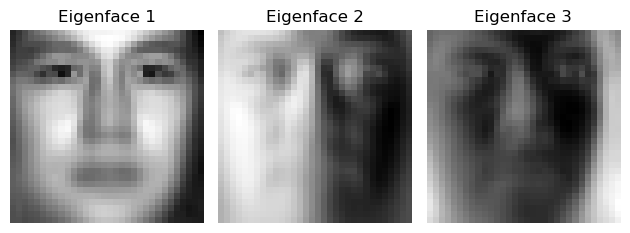

In [34]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(pca.get_eigenface(i), cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis(False)

plt.tight_layout()
plt.show()

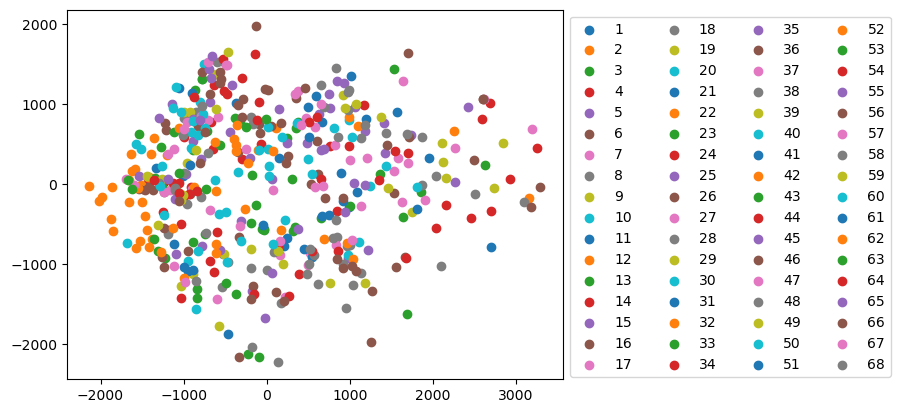

In [8]:
X_2d = pca.construct(train_set_data, dimension = 2)[:500,]
labels_500_sample = train_set_label[:500,]
labels_in_train_set = np.unique(labels_500_sample)
labels_in_train_set.sort()
for i in labels_in_train_set:
    plt.scatter(X_2d[labels_500_sample==i,0], X_2d[labels_500_sample==i,1], label = i)
plt.legend(ncol=4, bbox_to_anchor=(1, 1))
plt.show()

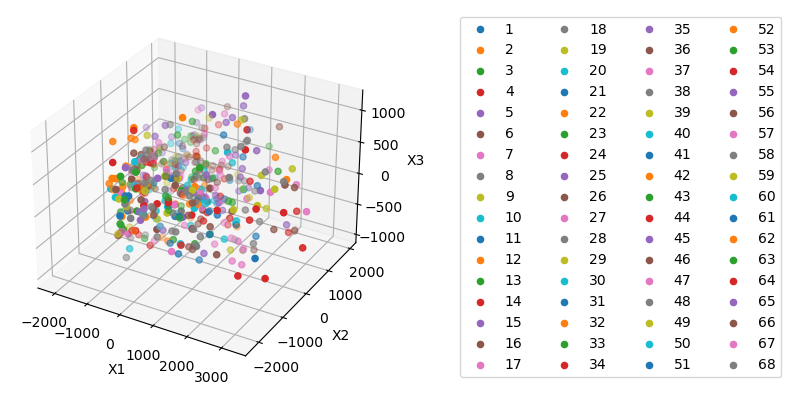

In [9]:
X_3d = pca.construct(train_set_data, dimension = 3)[:500]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in labels_in_train_set:
    ax.scatter(X_3d[labels_500_sample==i,0], X_3d[labels_500_sample==i,1], X_3d[labels_500_sample==i,2], label = i)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.legend(ncol=4, bbox_to_anchor=(1.2, 1))
plt.show()

In [10]:
class NearstNeighbor:
    def __init__(self, train_data, label):
        self.data = train_data
        self.label = label

    def compute_distance(A, B):
        distances = np.zeros((A.shape[0], B.shape[0]))
        for i, row_A in enumerate(A):
            for j, row_B in enumerate(B):
                distances[i, j] = np.linalg.norm(row_A - row_B)
        return distances
    
    def classify(self, test_data):
        distance = NearstNeighbor.compute_distance(test_data, self.data)
        index = np.argmin(distance, axis = 1)
        return self.label[index]
        

In [11]:
for d in [40, 80, 200]:
    X_train = pca.construct(train_set_data, dimension = d)
    X_test = pca.construct(test_set_data, dimension = d)
    NN = NearstNeighbor(X_train, train_set_label)
    predict_result = NN.classify(X_test)
    accuary = np.sum(predict_result == test_set_label)/predict_result.size
    print(f'Dimension {i}: Accuracy = {accuary}')

Dimension 68: Accuracy = 0.8985590778097983
Dimension 68: Accuracy = 0.9250720461095101
Dimension 68: Accuracy = 0.940057636887608
